![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

# Project: Analyzing Bitcoin crash

For this project, we will be reviewing the reasons for the most recent bitcoin crash.

We will be doing Visualizations, identifying trends and provide data-driven recommendations or information, so that every stakeholder, and myself of course, can take action.

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

Let's start by describing how the analysis will be taken. We will be using Python libraries (pandas, numpy and matplotlib) for the process. 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')

In [2]:
#let's import the dataset from the web and clean it
btc = pd.read_csv("https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1624646714&period2=1656182714&interval=1d&events=history&includeAdjustedClose=true") 
btc['Date'] = pd.to_datetime(btc['Date']) # parse Date from object to datetime64

btc.dropna() #drop null values, used btc.isnull().sum()
btc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-06-25,34659.105469,35487.246094,31350.884766,31637.779297,31637.779297,40230904226
1,2021-06-26,31594.664063,32637.587891,30184.501953,32186.277344,32186.277344,38585385521
2,2021-06-27,32287.523438,34656.128906,32071.757813,34649.644531,34649.644531,35511640894
3,2021-06-28,34679.121094,35219.890625,33902.074219,34434.335938,34434.335938,33892523752
4,2021-06-29,34475.558594,36542.109375,34252.484375,35867.777344,35867.777344,37901460044


Seems good to me, but for visualizing stocks, tipically we use the Daily Mean. Let's add it to the dataframe.

In [3]:
btc['Mean'] = (btc['Open'] + btc['Close']) / 2
btc.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Mean
0,2021-06-25,34659.105469,35487.246094,31350.884766,31637.779297,31637.779297,40230904226,33148.442383
1,2021-06-26,31594.664063,32637.587891,30184.501953,32186.277344,32186.277344,38585385521,31890.470703
2,2021-06-27,32287.523438,34656.128906,32071.757813,34649.644531,34649.644531,35511640894,33468.583985
3,2021-06-28,34679.121094,35219.890625,33902.074219,34434.335938,34434.335938,33892523752,34556.728516
4,2021-06-29,34475.558594,36542.109375,34252.484375,35867.777344,35867.777344,37901460044,35171.667969


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Identifying the crash

Now that we have a clean dataframe, let's begin analyzing it. First, let's quickly plot it so that we have a visual to base on.

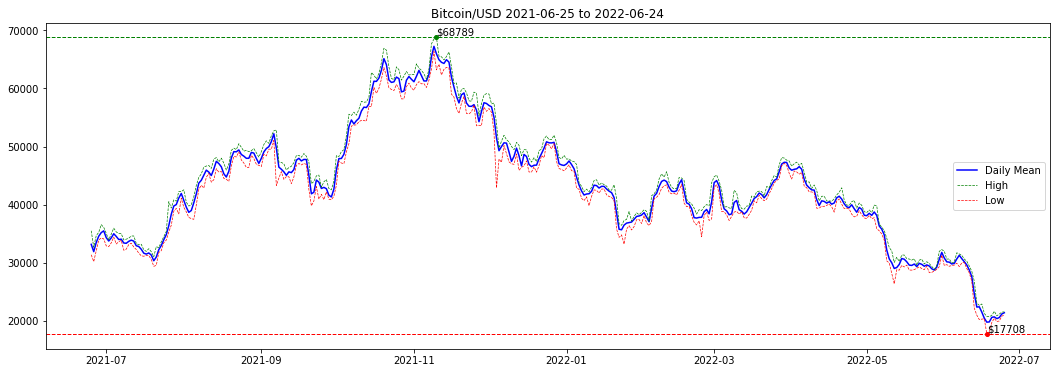

In [4]:
plt.figure(figsize=(18,6))
plt.title('Bitcoin/USD 2021-06-25 to 2022-06-24')
plt.plot(btc['Date'], btc['Mean'], color="blue", linewidth = 1.5)
plt.plot(btc['Date'], btc['High'], color = "green", linewidth=.7, linestyle='dashed')
plt.plot(btc['Date'], btc['Low'], color ="red", linewidth=.7, linestyle='dashed')
plt.legend(['Daily Mean', 'High', 'Low'])
plt.plot(btc.loc[btc['High'].max() == btc['High'], 'Date'], btc['High'].max(), marker="o", color = "green", markersize=4)
plt.plot(btc.loc[btc['Low'].min() == btc['Low'], 'Date'], btc['Low'].min(), marker="o", color = "red", markersize=4)
plt.axhline(y=btc['High'].max(), color='g', linestyle='dashed', linewidth=1, label="Maximo historico")
plt.axhline(y=btc['Low'].min(), color='r', linestyle='dashed', linewidth=1)
plt.annotate('${}'.format(int(btc['High'].max())), xy=(btc.loc[btc['High'].max() == btc['High'], 'Date'], btc['High'].max() + 400))
plt.annotate('${}'.format(int(btc['Low'].min())) , xy=(btc.loc[btc['Low'].min() == btc['Low'], 'Date'], btc['Low'].min() + 400))
plt.show()

As we can see on the graph, this stock is from 2021-06 to 2022-06. For a more detailed and complex analysis, we could use the historical, but we won't be needing it because our goal is to analyze the most recent bitcoin crash.

Even though there is an obvious drop in the price from 2021-11 to 2022-06, there are several market rebounds and trend reversals, that affect our analysis. 

As a simple explanation, a market rebound is when the price increase or decrease, and the price is not representative so it is corrected slightly by the market. 

A trend reversal is when a trend changed from decreasing to increasing (or viceversa). We can define a trend as a prediction of how the price will fluctuate in the future. If it is an increasing trend or bull market, the mins and maxs are higher everytime between rebounds. If it is a decreasing trend or bear market, the mins and maxs are lower.

Let's look for relevant maximums and minimums, we will be using the Daily Mean value of bitcoin.

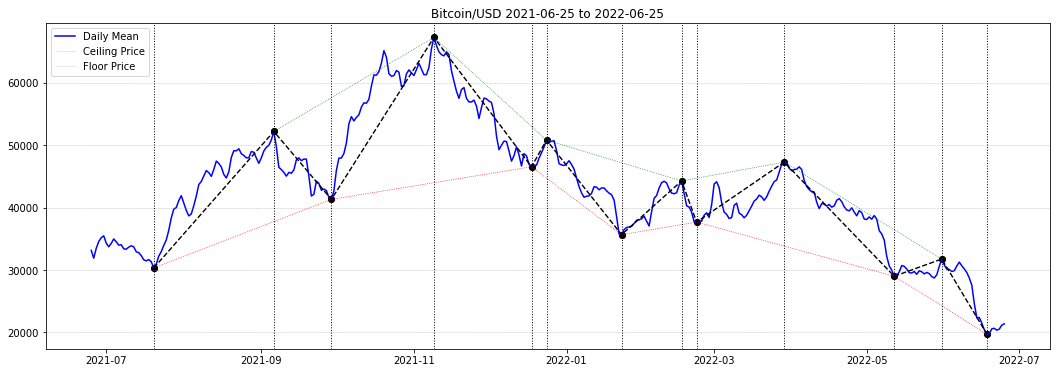

In [5]:
plt.figure(figsize=(18,6))
plt.title('Bitcoin/USD 2021-06-25 to 2022-06-25')
plt.plot(btc['Date'], btc['Mean'], color="blue", linewidth = 1.5)
#Draw visual reference for prices
[plt.axhline(y=i, color='gray', linewidth = .5, linestyle  = 'dashed', alpha=.5)  for i in [20000, 30000, 40000, 50000, 60000]]
maximums = []
minimums = []
ext = []
#Verify if value is local maximum or minimum and if it is preceeding a fall.
for x in range(0, btc['Mean'].shape[0]):
    if((btc['Mean'][x] - btc['Mean'][x-15:x].mean() > 0) & (btc['Mean'][x] == btc['Mean'][x-15:x+15].max()) & ((btc['Mean'][x] - btc['Mean'][x:x+25].mean() > 3000))): 
        maximums.append(x)
        ext.append(x)
    if((btc['Mean'][x] - btc['Mean'][x-15:x].mean() < -1000) & (btc['Mean'][x] == btc['Mean'][x-15:x+15].min())):
        minimums.append(x)
        ext.append(x)
df= pd.Series(maximums, dtype=float)
maxs = btc.loc[btc.index.isin(df)]
plt.plot(maxs['Date'], maxs['Mean'], color = "green", linestyle='dotted', linewidth=0.7)
plt.scatter(maxs['Date'], maxs['Mean'], color = "green")
df= minimums
mins = btc.loc[btc.index.isin(df)]
plt.plot(mins['Date'], mins['Mean'], color = "red", linestyle='dotted', linewidth=0.7)
plt.scatter(mins['Date'], mins['Mean'], color = "red")
plt.legend(['Daily Mean', 'Ceiling Price', 'Floor Price'])
df= ext
extremes = btc.loc[btc.index.isin(df)]
plt.plot(extremes['Date'], extremes['Mean'], color = "black", linestyle='dashed', linewidth=1.4)
plt.scatter(extremes['Date'], extremes['Mean'], color = "black")
[plt.axvline(x=i, color='black', linewidth = 1, linestyle  ='dotted',)  for i in extremes['Date']]
plt.show()

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Analyzing the crash

We now can clearly review the consecutive drops on the ceiling price and the floor price, that means we are in a overall bear market since 2021/11, with a market rebound during the period 2022/02 - 2022/04. Therefore, let's zoom into the last part of the graph and analyze this crash itself so we can make data driven recommendations.

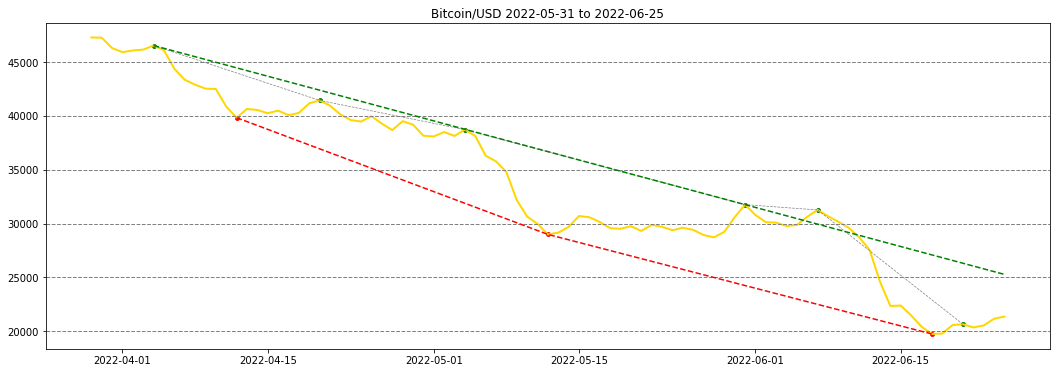

In [6]:
plt.figure(figsize=(18,6))
plt.title('Bitcoin/USD 2022-05-31 to 2022-06-25')
zoom = btc[btc[btc['Date'] == extremes.loc[extremes.index[-4], 'Date']].index[0]:]
plt.plot(zoom['Date'], zoom['Mean'], color="gold",linestyle="-", linewidth=2)
[plt.axhline(y=i, color='gray', linewidth = 1, linestyle  = 'dashed')  for i in [20000, 25000, 30000, 35000, 40000, 45000]]
ceil=pd.DataFrame()
floor=pd.DataFrame()
for x in range(0, btc['Mean'].shape[0] - extremes.index[-4]):
    if((zoom.loc[zoom.index[x], 'Mean'] - zoom.loc[zoom.index[x-1:x], 'Mean'].mean() > 0) & (zoom.loc[zoom.index[x], 'Mean'] == zoom.loc[zoom.index[x-3:x+3], 'Mean'].max()) & ((zoom.loc[zoom.index[x], 'Mean'] - zoom.loc[zoom.index[x:x+2], 'Mean'].mean() > 100))): 
        ceil = ceil.append(zoom.loc[zoom.index[x]])
    if((zoom.loc[zoom.index[x], 'Mean'] - zoom.loc[zoom.index[x-2:x], 'Mean'].mean() < -1000) & (zoom.loc[zoom.index[x], 'Mean'] == zoom.loc[zoom.index[x-5:x+5], 'Mean'].min())):
        floor = floor.append(zoom.loc[zoom.index[x]])
#itpl = interp1d(zoom.index, zoom['Mean'])
plt.plot(ceil['Date'], ceil['Mean'], color = "gray", linestyle='dashed', linewidth=0.7)
plt.scatter(ceil['Date'], ceil['Mean'], color = "green", s=15)
plt.plot(floor['Date'], floor['Mean'], color = "red", linestyle='dashed', linewidth=1.5)
plt.scatter(floor['Date'], floor['Mean'], color = "red", s=15)
#xnew = np.linspace(zoom.index[0], zoom.index[-1],100)
#plt.plot(xnew, itpl(xnew), '-', linewidth=10, color="red", alpha=.3)
ydist_c = zoom.loc[ceil.index[0], 'Mean'] - zoom.loc[ceil.index[3], 'Mean']
xdist_c= ceil.index[3] - ceil.index[0]
xdist2_c = zoom.index[-1] - ceil.index[0]
ydist2_c = zoom.loc[ceil.index[0], 'Mean'] - ((xdist2_c/xdist_c) * ydist_c)
yaxis_c = [zoom.loc[ceil.index[0], 'Mean'], ydist2_c]
xaxis_c = [zoom.loc[ceil.index[0], 'Date'], zoom.loc[zoom.index[-1], 'Date']]
#plt.plot(xaxis, yaxis, color="black", linestyle="dashed", linewidth="1")
plt.plot(xaxis_c, yaxis_c, color = "green", linestyle='dashed', linewidth=1.5)
plt.show()

As we can see, there are two dashed lines that represent ceil and floor. In market analysis and trading, we define ceil as the line between several maximum values, and therefore, floor is for minimum values. Trading is based on probabilities, so it's more likely that Bitcoin will remain between those two lines. Also, there was a minimum near the last date of the analysis, and chances are it will be similar to all those other rebounds: Bitcoin remained neutral for 2 weeks and then dropped again. 

There are three diferent relevant drops, let's start analyzing them.

In [7]:
drops = pd.DataFrame()
drops['Amount']= [zoom.loc[ceil.index[0], 'Mean'] - zoom.loc[floor.index[0], 'Mean']]
drops['Days'] = floor.index[0] - ceil.index[0]
drops['Amount_per_day'] = drops['Amount'] / drops['Days']
drops['Start'] = zoom.loc[ceil.index[0], 'Date']
drops['Finish'] = zoom.loc[floor.index[0], 'Date']
drops = drops.append(pd.Series(), ignore_index=True)
drops['Amount'][1] = zoom.loc[ceil.index[2], 'Mean'] - zoom.loc[floor.index[1], 'Mean']
drops['Days'][1] = floor.index[1] - ceil.index[2]
drops['Amount_per_day'][1] = drops['Amount'][1] / drops['Days'][1]
drops['Start'][1] = zoom.loc[ceil.index[2], 'Date']
drops['Finish'][1] = zoom.loc[floor.index[1], 'Date']
drops = drops.append(pd.Series(), ignore_index=True)
drops['Amount'][2] = zoom.loc[ceil.index[4], 'Mean'] - zoom.loc[floor.index[2], 'Mean']
drops['Days'][2] = floor.index[2] - ceil.index[4]
drops['Amount_per_day'][2] = drops['Amount'][2] / drops['Days'][2]
drops['Start'][2] = zoom.loc[ceil.index[4], 'Date']
drops['Finish'][2] = zoom.loc[floor.index[2], 'Date']
drops

,Amount,Days,Amount_per_day,Start,Finish
0,6703.525390,8.0,837.940674,2022-04-04,2022-04-12
1,9730.948243,8.0,1216.368530,2022-05-04,2022-05-12
2,11518.076173,11.0,1047.097834,2022-06-07,2022-06-18


We can see that each drop has a different amount, but we can't say that is bigger or lower because of that. We may need to take into consideration the timelapse of the drop. For reviewing which is the biggest drop of the crash, let's the Amount per day.

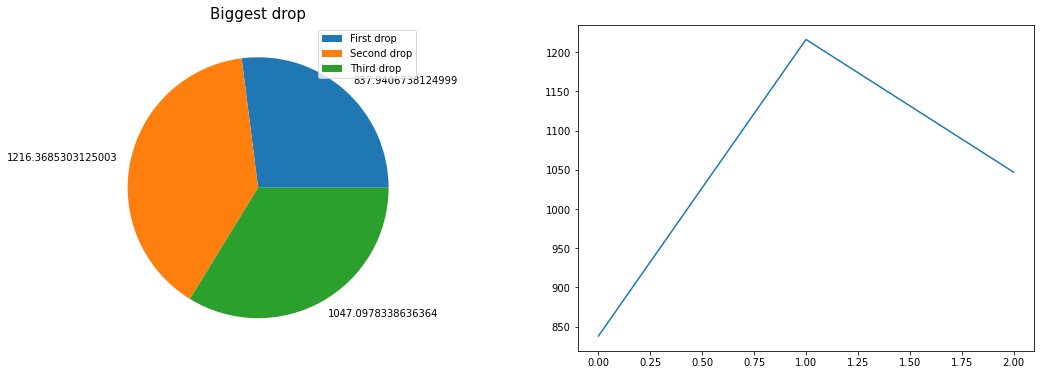

In [8]:
fig = plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
fig.patch.set_facecolor('White')
plt.title('Biggest drop', fontsize=15)
plt.pie(x= drops['Amount_per_day'], labels=drops["Amount_per_day"])
plt.legend(['First drop', 'Second drop', 'Third drop'])
plt.subplot(1,2,2)
plt.plot(drops['Amount_per_day'])
plt.show()

So we know that the biggest drop was the second one. Let's analyze the timelapse and the overall difference between the adjacent minimums.

In [25]:
adjmin = pd.DataFrame()
adjmin['Amount'] = [zoom.loc[floor.index[0], 'Mean'] - zoom.loc[floor.index[1], 'Mean']]
adjmin['Days'] = floor.index[1] - floor.index[0]
adjmin['Amount_per_day'] = adjmin['Amount'] / adjmin['Days']
adjmin['Start'] = zoom.loc[floor.index[0], 'Date']
adjmin['Finish'] = zoom.loc[floor.index[1], 'Date']
adjmin = adjmin.append(pd.Series(), ignore_index=True)
adjmin['Amount'][1]= zoom.loc[floor.index[1], 'Mean'] - zoom.loc[floor.index[2], 'Mean']
adjmin['Days'][1] = floor.index[2] - floor.index[1]
adjmin['Amount_per_day'][1] = adjmin['Amount'][1] / adjmin['Days'][1]
adjmin['Start'][1] = zoom.loc[floor.index[1], 'Date']
adjmin['Finish'][1]= zoom.loc[floor.index[2], 'Date']
adjmin


,Amount,Days,Amount_per_day,Start,Finish
0,10838.206055,30.0,361.273535,2022-04-12,2022-05-12
1,9246.708985,37.0,249.911054,2022-05-12,2022-06-18


We now see that the first crash period lasted 30 days and BTC dropped 10838, while the second crash period lasted 37 days and BTC dropped 9246, so that it was a smaller crash, and that is a good indicator because if we follow the trend and base on the ceil-floor lines, we can predict that the floor line will have a tight angle too, so that the fall will probably stop. 

If the next maximum is beyond the ceil line, we can predict that there will be a trend reversal, and that it will not fluctuate beyond the floor line.



![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)